# FIA-MS data processing and visualization

## Import dependencies

- Requires py v3.9 due to PyOpenMS dependencies
- Requires custom installation of BFAIR (see https://github.com/AutoFlowResearch/BFAIR for instructions on installation)

In [1]:
# General py packages
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

# BFAIR py package
import BFAIR.FIA_MS as fia_ms
import BFAIR.normalization as normalization

## Class and function definitions

Define functions and other shared sub-routines not yet integrated into the BFAIR modules

In [2]:
def removeConstFeatures(metabolites, intensities):
    """
    Remove singular or constant features
    
    Parameters
    ----------
    metabolites : list
        list of unique metabolites
    intensities : pandas.DataFrame
        the extracted intensities
    
    Returns
    -------
    intensities : pandas.DataFrame
        the filtered metabolites
    """
    for i, metabolite in enumerate(metabolites):
        row = intensities[intensities["Metabolite"] == metabolite]
        # filter out single- or constant-value features
        if len(row) == 1 or np.std(row["Intensity"]) == 0:
            index = intensities.index[intensities["Metabolite"] == metabolite].tolist()
            intensities = intensities.drop(labels= index, axis = 0)
    return intensities

def removeNAFeatures(metabolites, intensities, fraction=0.5):
    """
    Remove features with more than fraction of NAs
    
    Parameters
    ----------
    metabolites : list
        list of unique metabolites
    intensities : pandas.DataFrame
        the extracted intensities; modified in place
    fraction : float
        the fraction of missing values (i.e., NAs) allowed
    
    Returns
    -------
    intensities : pandas.DataFrame
        the filtered metabolites
    """
    intensities_filtered_pivot = intensities.pivot(index="sample_group_name", columns="Metabolite", values="Intensity")
    for i, metabolite in enumerate(metabolites):
        if intensities_filtered_pivot[metabolite].isna().sum() / intensities_filtered_pivot.shape[0] > fraction:
            index = intensities.index[intensities["Metabolite"] == metabolite].tolist()
            intensities = intensities.drop(labels= index, axis = 0)
    return intensities

def nonParametricRSD(intensities, threshold=0.3):
    """
    Determine the ratio of features in QC samples that
    have a non-parametric %RSD <= threshold
    
    Parameters
    ----------
    intensities : pandas.DataFrame
        the extracted intensities; modified in place
    threshold: float
        the threshold to use
    
    Returns
    -------
    stats_qc_df: pandas.DataFrame
        dataframe with columns for metabolites and the
        Mean, Var, RSD, and np_RSD of each metabolite
    ratio_np_RSD: float
        the ratio of features below the threshold
    ratio_RSD: float
        the ratio of features below the threshold
    """
    stats_qc_dict = {}

    for met in intensities["Metabolite"].unique():
        intensities_met = intensities[intensities["Metabolite"] == met]
        
        mean = np.mean(intensities_met["Intensity"])
        var = np.var(intensities_met["Intensity"])
        rsd = np.sqrt(var) / mean
        
        median = np.median(intensities_met["Intensity"])
        mad = np.median(np.absolute(intensities_met["Intensity"] - median))
        np_rsd = (1.4826 * mad) / median
        
        stats_qc_dict[met] = {"Mean" : mean,
                            "Var" : var,
                            "RSD" : rsd,
                            "np_RSD" : np_rsd}

    stats_qc_df = pd.DataFrame.from_dict(stats_qc_dict, "index")
    ratio_np_RSD = stats_qc_df[np.abs(stats_qc_df["np_RSD"]) <= threshold].shape[0] / stats_qc_df.shape[0]
    ratio_RSD = stats_qc_df[np.abs(stats_qc_df["RSD"]) <= threshold].shape[0] / stats_qc_df.shape[0]
    return stats_qc_df, ratio_np_RSD, ratio_RSD

def nonParametricDispersionRatio(intensities, intensities_QCs, threshold=0.5):
    """
    Determine the dispersion ratio of QC samples that
    have a non-parametric ratio <= threshold
    
    Parameters
    ----------
    intensities : pandas.DataFrame
        the extracted intensities;
    intensities_QCs : pandas.DataFrame
        the extracted intensities of only the QCs
    threshold: float
        the threshold to use
    
    Returns
    -------
    stats_qc: pandas.DataFrame
        dataframe with columns for metabolites and the
        dispersion ratio of each metabolite
    ratio_np: float
        the ratio of features below the threshold for
        the non parametric version
    ratio_p: float
        the ratio of features below the threshold for
        the parametric version
    """
    ratio_dict = {}

    for met in intensities["Metabolite"].unique():
        
        intensities_QC_met = intensities_QCs[intensities_QCs["Metabolite"] == met]
        median_qc = np.median(intensities_QC_met["Intensity"])
        mad_qc = np.median(np.absolute(intensities_QC_met["Intensity"] - median_qc))
        sd_qc = np.std(intensities_QC_met["Intensity"])
        
        intensities_met = intensities[intensities["Metabolite"] == met]
        median = np.median(intensities_met["Intensity"])
        mad = np.median(np.absolute(intensities_met["Intensity"] - median))
        sd = np.std(intensities_met["Intensity"])
        
        ratio_np = mad_qc / mad
        ratio_p = sd_qc / sd

        ratio_dict[met] = {"dispersion_ratio_np" : ratio_np,
            "dispersion_ratio_p" : ratio_p}

    dispersion_ratio_df = pd.DataFrame.from_dict(ratio_dict, "index")
    dispersion_ratio_np = dispersion_ratio_df[dispersion_ratio_df["dispersion_ratio_np"] <= threshold].shape[0] / dispersion_ratio_df.shape[0]
    dispersion_ratio_p = dispersion_ratio_df[dispersion_ratio_df["dispersion_ratio_p"] <= threshold].shape[0] / dispersion_ratio_df.shape[0]
    return dispersion_ratio_df, dispersion_ratio_np, dispersion_ratio_p

def plotPCAwAnnotations(pca, data_plot, show_colors=True, show_labels=True):
    """
    Plot PCA Scree plot and PCA data for axes 1 to 3
    
    Parameters
    ----------
    pca : pandas.DataFrame
        Result of SciKitLearn PCA fit_transform
    data_plot : pandas.DataFrame
        The extracted PCA components (i.e., first 10) with additional
        metadata for "sample_group_name", "replicate_group_name", and "color"
    show_colors: boolean
        color the points using the "color" column
    show_labels: boolean
        show the "sample_group_name"
    
    Returns
    -------
    none
    """
    # Scree plot
    PC_values = np.arange(pca.n_components_) + 1
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_title('Scree Plot')
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Variance Explained')
    ax.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')

    # Scores plots
    for j in range(1,4):
        for k in range(j+1,4):

            # Create a subplot for each PCA axis combination
            fig = plt.figure(figsize = (8,8))
            ax = fig.add_subplot(1,1,1) 
            ax.set_xlabel('Principal Component ' + str(j) + ' ( ' + str(round(pca.explained_variance_ratio_[j-1], 2)) + ' )' , fontsize = 20)
            ax.set_ylabel('Principal Component ' + str(k) + ' ( ' + str(round(pca.explained_variance_ratio_[k-1], 2)) + ' )' , fontsize = 20)
            ax.set_title('PCA (Axis' + str(j) + ' & ' + str(k) + ')', fontsize = 20)

            plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.1)
            plt.xticks(size = 20)
            plt.yticks(size = 20)

            if show_colors:
                # Loop through each PCA axis
                for i, label in enumerate(data_plot["sample_group_name"]):
                    x, y = data_plot["pca" + str(j)][i], data_plot["pca" + str(k)][i]
                    ax.plot(x, y, ".", markersize=15, label=label, color=data_plot["color"][i])
                    
                    if show_labels:
                        # Annotate the points with the actual names and colors as rounded boxes (only for small sample sizes)
                        ax.annotate(data_plot["sample_group_name"][i], (x - 0.5 , y), weight='bold',
                                    color='white',
                                    bbox=dict(boxstyle="round",
                                    facecolor=data_plot["color"][i], edgecolor=data_plot["color"][i],
                                )
                                )
            else:           
                plt.scatter(data_plot["pca" + str(j)], data_plot["pca" + str(k)], c=labels_clust, s=50, cmap='Spectral')

def addReplicateGroupNameToDF(df, sequence):
    """
    Add the replicate group name to the Metabolite/sample_group_name/Intensities dictionary
    
    Parameters
    ----------
    df : pandas.DataFrame
        the extracted intensities;
    sequence : pandas.DataFrame
        the sequence list corresponding to the extracted intensities
    
    Returns
    -------
    df : pandas.DataFrame
        the update dataframe
    """
    # Add in the replicate group name
    df["replicate_group_name"] = ""
    def getRGNFromSeq(x, seq):
        index = np.where(seq["sample_group_name"] == x)
        return seq["replicate_group_name"][index[0][0]]
    df["replicate_group_name"] = df["sample_group_name"].apply(getRGNFromSeq, seq=sequence)
    return df

## Read in the data

Set the directories

In [3]:
work_dir = "C:/Users/dmccl/Downloads"
batch_name = "NPDemo"
run_name = "Orbitrap1"
load_from_cache = True

if run_name == "Bruker":
    feature_dir = "Z:/Douglas/AutoFlow data/AFS Experiments/AFS-43-103_FIA-MS_MetEng-NP/features_Bruker"
    sequence_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20211212_FIA-MS_MetEngNPDemo/MetEng-NP-01_ScimaX"
    database_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20211212_FIA-MS_MetEngNPDemo/CHEMISTRY"
    if batch_name == "MetEngDemo":
        database_file = "/yeastGEM-Tab-Str_struct.tsv"
        sequence_file = "/sequence_SCerevisiae.csv"
        intensities_file = "/MetEngDemo_Bruker_Intensities.csv"
        MeanVarRSD_file = "/MetEngDemo_Bruker_MeanVarRSD.csv"
    else:
        database_file = "/streptomyces-endo-exo_struct.tsv"
        sequence_file = "/sequence_Strep.csv"
        intensities_file = "/NPDemo_Bruker_Intensities.csv"
        MeanVarRSD_file = "/NPDemo_Bruker_MeanVarRSD.csv"
elif run_name == "Orbitrap1":
    feature_dir = "Z:/Douglas/AutoFlow data/AFS Experiments/AFS-43-103_FIA-MS_MetEng-NP/features_DTU"
    sequence_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20211212_FIA-MS_MetEngNPDemo/MetEng-NP-01_Orbitrap"
    database_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20211212_FIA-MS_MetEngNPDemo/CHEMISTRY"
    if batch_name == "MetEngDemo":
        database_file = "/yeastGEM-Tab-Str_struct.tsv"
        sequence_file = "/sequence_SCerevisiae.csv"
        intensities_file = "/MetEngDemo_Orbitrap1_Intensities.csv"
        MeanVarRSD_file = "/MetEngDemo_Orbitrap1_MeanVarRSD.csv"
    else:
        database_file = "/streptomyces-endo-exo_struct.tsv"
        sequence_file = "/sequence_Strep.csv"
        intensities_file = "/NPDemo_Orbitrap1_Intensities.csv"
        MeanVarRSD_file = "/NPDemo_Orbitrap1_MeanVarRSD.csv"
elif run_name == "Orbitrap2":
    feature_dir = "Z:/Douglas/AutoFlow data/AFS Experiments/AFS-43-103_FIA-MS_MetEng-NP/features_round2"
    sequence_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20211212_FIA-MS_MetEngNPDemo/MetEng-NP-02_Orbitrap"
    database_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20211212_FIA-MS_MetEngNPDemo/CHEMISTRY"
    if batch_name == "MetEngDemo":
        database_file = "/yeastGEM-Tab-Str_struct.tsv"
        sequence_file = "/sequence_SCerevisiae.csv"
        intensities_file = "/MetEngDemo_Orbitrap2_Intensities.csv"
        MeanVarRSD_file = "/MetEngDemo_Orbitrap2_MeanVarRSD.csv"
    else:
        database_file = "/streptomyces-endo-exo_struct.tsv"
        sequence_file = "/sequence_Strep.csv"
        intensities_file = "/NPDemo_Orbitrap2_Intensities.csv"
        MeanVarRSD_file = "/NPDemo_Orbitrap2_MeanVarRSD.csv"

Read in the sequence and remove blank rows

<AxesSubplot:xlabel='sample_name'>

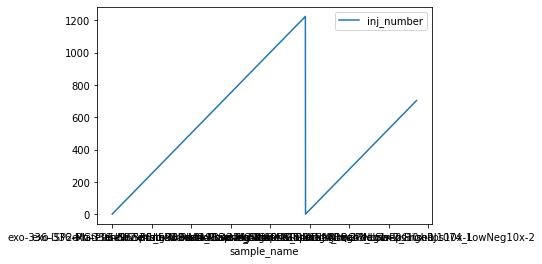

In [4]:
sequence = pd.read_csv(sequence_dir + sequence_file, sep=",")
sequence = sequence[sequence["sample_name"].str.contains("BLANK") == False]

# Quick QC of the data
sequence.plot(x="sample_name", y="inj_number", kind="line")

Read in the database file

In [5]:
database = pd.read_csv(database_dir + database_file, sep="\t", header=None)
database = database.drop(database[database.iloc[:,0].str.contains("EXTRA")].index)

Extract all the relevant information from the provided .featureXML files

In [6]:
# Read in the intensities for .FeatureXML
if load_from_cache:
    intensities = pd.read_csv(work_dir + intensities_file)
else:
    intensities = fia_ms.extractNamesAndIntensities(feature_dir, sequence["sample_group_name"].unique(), database)
    
    # Remove "HMDB:" from metabolite IDs
    #intensities["Metabolite"] = intensities["Metabolite"].str.replace("HMDB:", "")

    # Export to csv
    intensities.to_csv(work_dir + intensities_file)

<AxesSubplot:xlabel='sample_group_name'>

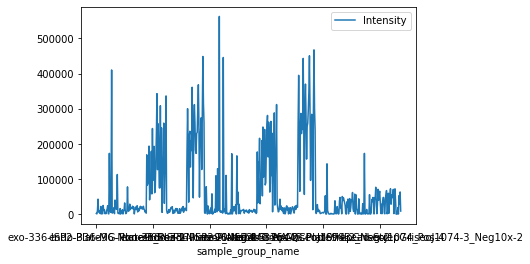

In [7]:
# Quick QC of the data
intensities_selected = intensities[intensities["Metabolite"] == "glu_D[c]"]
intensities_selected.plot(x="sample_group_name", y="Intensity", kind="line")

## Data filtering, normalization, quality control (QC), and basic statistical analysis

Data filtering #1: remove single and constant value features

In [8]:
metabolites = intensities["Metabolite"].unique()

intensities_filtered = removeConstFeatures(metabolites, intensities)
print("Intensities ", intensities.shape[0])
print("Intensities filtered ", intensities_filtered.shape[0])
print("Intensities difference ", intensities.shape[0] - intensities_filtered.shape[0])

Intensities  351729
Intensities filtered  351729
Intensities difference  0


Date filtering #2: remove features with more than 50% NAs

In [9]:
metabolites = intensities_filtered["Metabolite"].unique()

intensities_filtered = removeNAFeatures(metabolites, intensities_filtered, 0.99)
print("Percent filtered ", 100 * (1 - (intensities_filtered.shape[0]/intensities.shape[0])))

Percent filtered  0.0


Data QC #1: non-parametric %RSD

In [10]:
intensities_QC = intensities_filtered[intensities_filtered["sample_group_name"].str.contains("QC")]

stats_qc_df, ratio_np_RSD, ratio_RSD = nonParametricRSD(intensities_QC)
print("Percent QC features with NP RSD <= 0.3 ", ratio_np_RSD)
print("Percent QC features with RSD <= 0.3 ", ratio_RSD)

Percent QC features with NP RSD <= 0.3  0.018439716312056736
Percent QC features with RSD <= 0.3  0.011347517730496455


Data QC #2: non-parametric dispersion ratio

In [11]:
intensities_QC = intensities_filtered[intensities_filtered["sample_group_name"].str.contains("QC")]

dispersion_ratio_df, dispersion_ratio_np, dispersion_ratio_p = nonParametricDispersionRatio(intensities_filtered, intensities_QC)
print("Percent non parametric dispersion ratio <= 0.5 ", dispersion_ratio_np)
print("Percent parametric dispersion ratio <= 0.5 ", dispersion_ratio_p)

Percent non parametric dispersion ratio <= 0.5  0.16973125884016974
Percent parametric dispersion ratio <= 0.5  0.5417256011315418


c:\Users\dmccl\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\dmccl\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Data normalize #1: Total sum intensity (tsi) sample normalization and log transformation

array([[<AxesSubplot:title={'center':'Intensity'}>]], dtype=object)

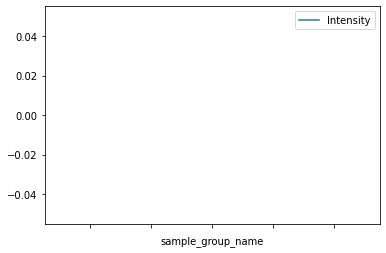

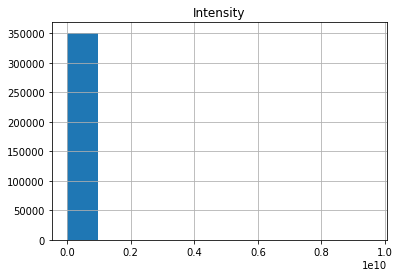

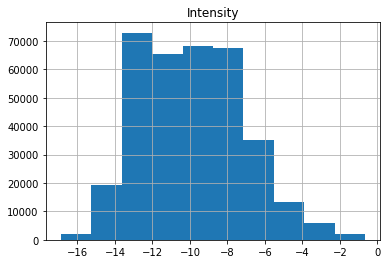

In [12]:
intensities_tsi = normalization.tsi_norm(intensities_filtered)
intensities_tsi["Intensity"] = np.log(intensities_tsi["Intensity"])

intensities_selected = intensities[intensities["Metabolite"] == "8__hydroxygeraniol"]
#intensities_selected = intensities[intensities["Metabolite"] == "glu_D[c]"]
intensities_selected.plot(x="sample_group_name", y="Intensity", kind="line")
intensities_filtered.hist("Intensity")
intensities_tsi.hist("Intensity")

Data QC #3: parametric %RSD

In [13]:
normalized_intensities_QC = intensities_tsi[intensities_tsi["sample_group_name"].str.contains("QC")]
stats_qc_df, ratio_np_RSD, ratio_RSD = nonParametricRSD(normalized_intensities_QC)
print("Percent QC features with NP RSD <= 0.3 ", ratio_np_RSD)
print("Percent QC features with RSD <= 0.3 ", ratio_RSD)

Percent QC features with NP RSD <= 0.3  0.9333333333333333
Percent QC features with RSD <= 0.3  0.9475177304964539


Data QC #4: parametric dispersion ratio

In [14]:
normalized_intensities_QC = intensities_tsi[intensities_tsi["sample_group_name"].str.contains("QC")]
dispersion_ratio_df, dispersion_ratio_np, dispersion_ratio_p = nonParametricDispersionRatio(intensities_tsi, normalized_intensities_QC)
print("Percent non parametric dispersion ratio <= 0.5 ", dispersion_ratio_np)
print("Percent parametric dispersion ratio <= 0.5 ", dispersion_ratio_p)


Percent non parametric dispersion ratio <= 0.5  0.25742574257425743
Percent parametric dispersion ratio <= 0.5  0.157001414427157


c:\Users\dmccl\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\dmccl\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Data filtering #3: remove high variable features (QC > 30% RSD)

In [15]:
to_discard = stats_qc_df[np.abs(stats_qc_df["RSD"]) > 0.3]
to_discard.index.name = 'Metabolite'
to_discard.reset_index(inplace=True)
intensities_tsi_filt = intensities_tsi[~intensities_tsi["Metabolite"].isin(to_discard["Metabolite"])]

print("Intensities ", intensities_tsi.shape[0])
print("Intensities filtered ", intensities_tsi_filt.shape[0])
print("Intensities difference ", intensities_tsi.shape[0] - intensities_tsi_filt.shape[0])

Intensities  351729
Intensities filtered  325038
Intensities difference  26691


Data filtering #4: remove samples without the minimum number of replicates and highly variable features (> 50% RSD)

In [16]:
%%capture
if load_from_cache:
    intensities_stats = pd.read_csv(work_dir + MeanVarRSD_file)
else:
    intensities_stats = fia_ms.calculateMeanVarRSD(intensities_tsi_filt, sequence.drop_duplicates(["sample_group_name", "replicate_group_name"]), min_reps=2)

    # Export to csv
    intensities_stats.to_csv(work_dir + MeanVarRSD_file)

In [17]:
# Filter metabolites
to_discard = intensities_stats[np.abs(intensities_stats["RSD"]) > 0.5]
to_discard_mets = to_discard["Metabolite"].unique()

# Filter sample_group_names
outlier_rgns = ["exo-48-SD-None-CKO-3-3-Neg10x-1", "exo-48-SD-None-CKO-3-3-Neg10x-2", "endo-48-SD-None-CKO-3-3-Neg10x-1", "endo-48-SD-None-CKO-3-3-Neg10x-2",
    "exo-48-SD-None-CKO-3-3-Pos10x-1", "exo-48-SD-None-CKO-3-3-Pos10x-2", "endo-48-SD-None-CKO-3-3-Pos10x-1", "endo-48-SD-None-CKO-3-3-Pos10x-2"]
to_keep_injections = sequence[sequence["replicate_group_name"].isin(intensities_stats["replicate_group_name"]) & ~sequence["sample_group_name"].isin(outlier_rgns)]

intensities_tsi_filt2 = intensities_tsi_filt[~intensities_tsi_filt["Metabolite"].isin(to_discard_mets) & intensities_tsi_filt["sample_group_name"].isin(to_keep_injections["sample_group_name"].unique())]
print("n discarded metabolites", len(to_discard_mets))
print("Intensities ", intensities_tsi_filt.shape[0])
print("Intensities filtered ", intensities_tsi_filt2.shape[0])
print("Intensities difference ", intensities_tsi_filt.shape[0] - intensities_tsi_filt2.shape[0])

n discarded metabolites 11
Intensities  325038
Intensities filtered  316755
Intensities difference  8283


Data QC #5: Visualization of the RSD

Text(0.5, 1.0, 'RSD')

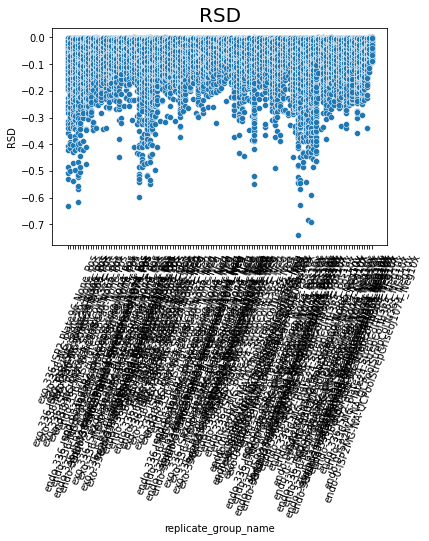

In [18]:
sns.scatterplot(x="replicate_group_name", y="RSD", data=intensities_stats)
plt.xticks(rotation=70)
plt.title('RSD', size = 20)

Data QC #???: background interference

In [85]:
def backgroundInterference(intensities_blanks, intensities_unknowns, threshold=0.8, geometric=False):
    """
    Determine the ratio of features in Blanks samples that
    have a median intensity > threshold
    
    Parameters
    ----------
    intensities_blanks : pandas.DataFrame
        the extracted intensities for the Blank samples
    intensities_blanks : pandas.DataFrame
        the extracted intensities for the Unknown (or QC) samples
    threshold: float
        the threshold to use
    geometric: boolean
        whether to apply the threshold in geomtric space
    
    Returns
    -------
    stats_interference_df: pandas.DataFrame
        dataframe with columns for metabolites and the
        Mean, Median, Var, RSD of each metabolite
    intensities_filtered_df: pandas.DataFrame
        the extracted intensities for the Unknown (or QC) samples 
        filtered after applying the threshold
    n_intensities_removed: float
        the number of intensities in the Unknown (or QC) samples
        that were > threshold*intensity_blank
    """
    stats_blanks_dict = {}
    intensities_filtered_df = pd.DataFrame(columns=intensities_unknowns.columns)
    for met in intensities_blanks["Metabolite"].unique():
        # Determine the blank intensity statistics
        intensities_met = intensities_blanks[intensities_blanks["Metabolite"] == met]        
        mean = np.mean(intensities_met["Intensity"])
        var = np.var(intensities_met["Intensity"])
        rsd = np.sqrt(var) / mean        
        median = np.median(intensities_met["Intensity"])
        mad = np.median(np.absolute(intensities_met["Intensity"] - median))
        np_rsd = (1.4826 * mad) / median        
        stats_blanks_dict[met] = {"Mean" : mean, "Var" : var,
            "Median": median, "RSD" : rsd, "np_RSD" : np_rsd}

        # Filter out metabolites that are > threshold * median
        threshold_cmp = threshold * median
        if geometric:
            threshold_cmp = np.log(threshold) + median
        else:
            if threshold_cmp < 0:
                threshold_cmp = 1 / threshold * median
        intensities_tmp = intensities_unknowns[(intensities_unknowns["Metabolite"] == met) & (intensities_unknowns["Intensity"] > threshold_cmp)]
        tmp = intensities_unknowns[(intensities_unknowns["Metabolite"] == met)]
        intensities_filtered_df = pd.concat([intensities_filtered_df, intensities_tmp], ignore_index=True)
        
    # Finalize the outputs
    stats_interference_df = pd.DataFrame.from_dict(stats_blanks_dict, "index")
    n_intensities_removed = intensities_unknowns.shape[0] - intensities_filtered_df.shape[0]
    return stats_interference_df, intensities_filtered_df, n_intensities_removed

In [88]:
# Blanks and Unknowns/QCs
sequence_blanks = sequence[sequence["sample_type"].str.contains("Blank")]
sequence_unknowns = sequence[~sequence["sample_type"].str.contains("Blank")]
normalized_intensities_Blanks = intensities_tsi_filt2[intensities_tsi_filt2["sample_group_name"].isin(sequence_blanks["sample_group_name"])]
normalized_intensities_Unknowns = intensities_tsi_filt2[intensities_tsi_filt2["sample_group_name"].isin(sequence_unknowns["sample_group_name"])]

# Remove background interferences
stats_interference_df, intensities_filtered_df, n_intensities_removed = backgroundInterference(normalized_intensities_Blanks, normalized_intensities_Unknowns, 0.8, True)
print("N intensities > 0.8 ", n_intensities_removed)
print("N intensities > 0.8 ", intensities_filtered_df.shape[0])
print("Percent intensities > 0.8 ", n_intensities_removed/normalized_intensities_Unknowns.shape[0])

N intensities > 0.8  76096
N intensities > 0.8  112660
Percent intensities > 0.8  0.40314480069507724


Data QC #5: PCA of replicates, blanks, and QCs

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [92]:
# Split into smaller subsets by batch, polarity, compartment, etc.
batch_names = ["MetEngDemo","NPDemo"]
scan_polaritie = ["positive","negative"]
sample_types = ["Blank","QC","Unknown"]
cellular_locations = ["exo-", "endo-"]

time_points = ["48","96","144"]
media_types = ["MG","ISP2"]
media_types = ["YPDFeed-None","YPDFeed-Supp","YPDNoFeed-None","YPDNoFeed-Supp"]

time_points = ["0","336","144"]
plate_types = ["Plate96","Plate96Bead","Plate96Spring","Plate24","Plate24Bead","Plate24Spring"]
cell_types = ["StrepColTu365", "StrepGriseoJ1074"]

# Define the sequence subsets using the pattern batch_name/scan_polarity/sample_type/cellular_location
sequence_MetEngDemo_Pos_NA_NA = sequence[sequence["batch_name"].str.contains("MetEngDemo") 
    & sequence["scan_polarity"].str.contains("positive") 
    #& sequence["sample_type"].str.contains("Unknown")
    #& sequence["replicate_group_name"].str.contains("endo-")
    #& sequence["replicate_group_name"].str.contains("48-")
    ]
sequence_MetEngDemo_NA_QC_NA = sequence[sequence["batch_name"].str.contains("MetEngDemo") 
    #& sequence["scan_polarity"].str.contains("positive") 
    #& sequence["sample_type"].str.contains("QC")
    & (sequence["sample_type"].str.contains("QC") | sequence["sample_type"].str.contains("Blank"))
    #& sequence["replicate_group_name"].str.contains("endo-")
    #& sequence["replicate_group_name"].str.contains("48-")
    ]
sequence_MetEngDemo_Pos_Unknown_endo = sequence[sequence["batch_name"].str.contains("MetEngDemo") 
    & sequence["scan_polarity"].str.contains("positive") 
    & sequence["sample_type"].str.contains("Unknown")
    & sequence["replicate_group_name"].str.contains("exo-")
    #& sequence["replicate_group_name"].str.contains("144-")
    & (sequence["dilution_factor"] == 10.0)
    ]
sequence_MetEngDemo_Pos_Unknown_exo = sequence[sequence["batch_name"].str.contains("MetEngDemo") 
    & sequence["scan_polarity"].str.contains("positive") 
    & sequence["sample_type"].str.contains("Unknown")
    & sequence["replicate_group_name"].str.contains("exo-")
    & sequence["replicate_group_name"].str.contains("48-")
    ]

sequence_NPDemo_Pos_Unknown_exo = sequence[sequence["batch_name"].str.contains(r'\b(?:{})\b'.format('|'.join(["NPDemo","NatProdDemo"])))
    & sequence["scan_polarity"].str.contains("positive") 
    #& sequence["sample_type"].str.contains("Unknown")
    & sequence["sample_type"].str.contains("Unknown")
    & sequence["replicate_group_name"].str.contains("endo-")
    #& sequence["replicate_group_name"].str.contains("48-")
    ]
sequence_NPDemo_NA_QC_NA = sequence[sequence["batch_name"].str.contains(r'\b(?:{})\b'.format('|'.join(["NPDemo","NatProdDemo"])))
    #& sequence["scan_polarity"].str.contains("positive") 
    & sequence["sample_type"].str.contains("QC")
    #& (sequence["sample_type"].str.contains("QC") | sequence["sample_type"].str.contains("Blank"))
    #& sequence["replicate_group_name"].str.contains("endo-")
    #& sequence["replicate_group_name"].str.contains("48-")
    ]

# Create the subset and pivot table
intensities_subset = intensities_filtered_df[intensities_filtered_df["sample_group_name"].isin(sequence_NPDemo_Pos_Unknown_exo["sample_group_name"].unique())]
intensities_piv = intensities_subset.pivot("sample_group_name", "Metabolite", "Intensity")
intensities_piv = intensities_piv.fillna(0)
print(intensities_piv.shape[0])

160


In [94]:
# Standardize the data
scaler = StandardScaler()
intensities_piv_scaled = scaler.fit_transform(intensities_piv)

# pca
pca = PCA(n_components = 10)
comps = pca.fit_transform(intensities_piv_scaled)

In [95]:
# plot the scores
data_plot = pd.DataFrame(data = comps, columns =  ['pca1', 'pca2',
    'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10'])

# add in the sample_group_names as the labels
labels = intensities_piv.index
data_plot["sample_group_name"] = intensities_piv.index

# add in the replicate_group_name to define the colors
data_plot["replicate_group_name"] = ""
for i,row in data_plot.iterrows():
    index = np.where(sequence["sample_group_name"] == row["sample_group_name"])[0]
    data_plot.loc[:, "replicate_group_name"].iloc[i] = sequence["replicate_group_name"][index[0]]

# define the colors based on various criteria
# color palette = ["#000000", "#929292", "#0037ea", "#00b5ff", "#4cfeb2", "#4c98fe", "#f1fe4c", "#fe594c", "#feb24c"]
data_plot.loc[:, "color"] = ""
annotation = "species"
for i,row in data_plot.iterrows():
    if annotation == "QC":
        ## MetEengDemo
        if row["replicate_group_name"] == "exo-0-YPDSD-NA-QCPool_Pos":
            data_plot.loc[:, "color"].iloc[i] = "#000000"
        elif row["replicate_group_name"] == "exo-0-YPDSD-NA-QCPool_Neg":
            data_plot.loc[:, "color"].iloc[i] = "#929292"
        elif row["replicate_group_name"] == "endo-0-YPDSD-NA-QCPool_Pos":
            data_plot.loc[:, "color"].iloc[i] = "#4cfeb2"
        elif row["replicate_group_name"] == "endo-0-YPDSD-NA-QCPool_Neg":
            data_plot.loc[:, "color"].iloc[i] = "#b24cfe"
        elif "None-None" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#4c98fe"
        elif "QCCellFilt" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#feb24c"
        elif "Supp-None" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#fe594c"
        ## NPDemo
        elif "endo-0-ISP2MG-NA-QCPoolStrepColTu365_Neg" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#000000"
        elif "endo-0-ISP2MG-NA-QCPoolStrepColTu365_Pos" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#929292"
        elif "endo-0-ISP2MG-NA-QCPoolStrepGriseoJ1074_Neg" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#4cfeb2"
        elif "endo-0-ISP2MG-NA-QCPoolStrepGriseoJ1074_Pos" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#b24cfe"
        elif "exo-0-ISP2MG-NA-QCPoolStrepColTu365_Neg" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#4c98fe"
        elif "exo-0-ISP2MG-NA-QCPoolStrepColTu365_Pos" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#feb24c"
        elif "exo-0-ISP2MG-NA-QCPoolStrepGriseoJ1074_Neg" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#fe594c"
        elif "exo-0-ISP2MG-NA-QCPoolStrepGriseoJ1074_Pos" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#f1fe4c"
        else:
            data_plot.loc[:, "color"].iloc[i] = "#feb24c"

    elif annotation == "cellular_location":
        if "exo" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#000000"
        elif "endo" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#929292"
        else:
            data_plot.loc[:, "color"].iloc[i] = "#feb24c"

    elif annotation == "scan_mode":
        if "Pos" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#000000"
        elif "Neg" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#929292"
        else:
            data_plot.loc[:, "color"].iloc[i] = "#feb24c"

    elif annotation == "dilution":
        if "1x" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#000000"
        elif "10x" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#929292"
        else:
            data_plot.loc[:, "color"].iloc[i] = "#feb24c"

    elif annotation == "time":
        if "48" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#000000"
        elif "96" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#929292"
        elif "144" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#4c98fe"
        elif "0" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#b24cfe"
        else:
            data_plot.loc[:, "color"].iloc[i] = "#feb24c"

    elif annotation == "species":
        if "StrepColTu365" in row["replicate_group_name"] or "collinus" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#000000"
        elif "StrepGriseoJ1074" in row["replicate_group_name"] or "griseofuscus" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#929292"
        elif "albus" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#4c98fe"
        elif "coelicolor" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#b24cfe"
        else:
            data_plot.loc[:, "color"].iloc[i] = "#feb24c"

    elif annotation == "media":
        ## MetEngDemo
        if "YPDFeed-None" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#000000"
        elif "YPDFeed-Supp" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#929292"
        elif "YPDNoFeed-None" in row["replicate_group_name"] or "YPD-None" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#4c98fe"
        elif "YPDNoFeed-Supp" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#b24cfe"
        elif "SD-None" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#fe594c"
        elif "SD-Supp" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#feb24c"
        elif "SDFeed-Supp" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#fe594c"
        # elif "YPDNoFeed-Supp" in row["replicate_group_name"]:
        #     data_plot.loc[:, "color"].iloc[i] = "#f1fe4c"
        ## NPDemo (Also DNPM)
        elif "ISP2-Plate96" in row["replicate_group_name"] or "96well_ISP2" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#000000"
        elif "MG-Plate96" in row["replicate_group_name"] or "96well_MG" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#929292"
        elif "ISP2-Plate24" in row["replicate_group_name"] or "24well_ISP2" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#4c98fe"
        elif "MG-Plate24" in row["replicate_group_name"] or "24well_MG" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#b24cfe"
        elif "96well_DNPM" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#4c98fe"
        elif "24well_DNPM" in row["replicate_group_name"]:
            data_plot.loc[:, "color"].iloc[i] = "#feb24c"
        else:
            data_plot.loc[:, "color"].iloc[i] = "#feb24c"

C:\Users\dmccl\AppData\Local\Temp\ipykernel_45468\4208765856.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot.loc[:, "replicate_group_name"].iloc[i] = sequence["replicate_group_name"][index[0]]
C:\Users\dmccl\AppData\Local\Temp\ipykernel_45468\4208765856.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot.loc[:, "color"].iloc[i] = "#000000"
C:\Users\dmccl\AppData\Local\Temp\ipykernel_45468\4208765856.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\dmccl\AppData\Local\Temp\ipykernel_45468\1324052703.py:186: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.1)


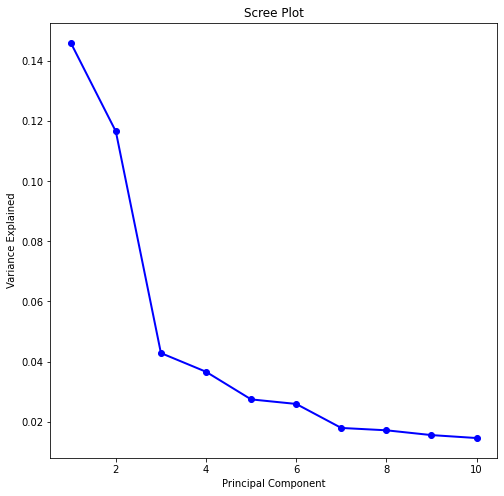

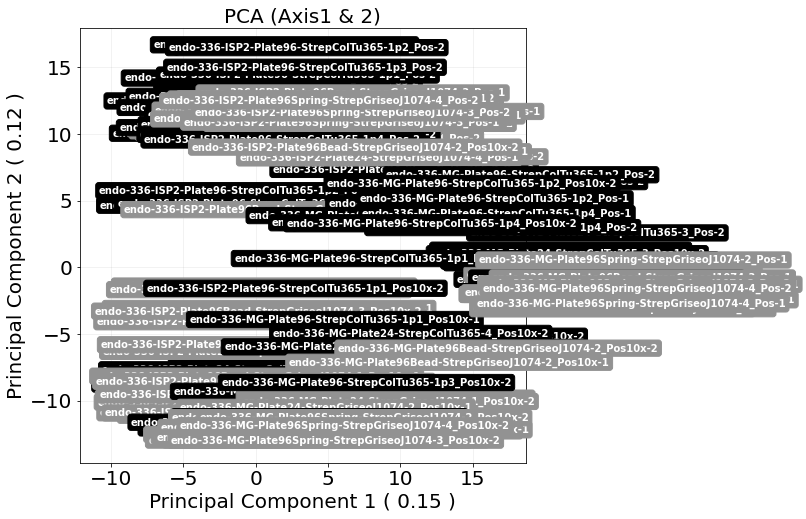

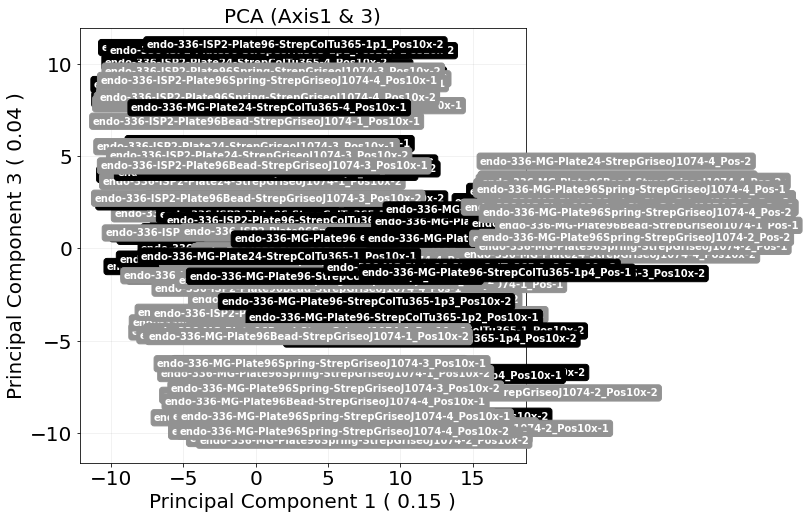

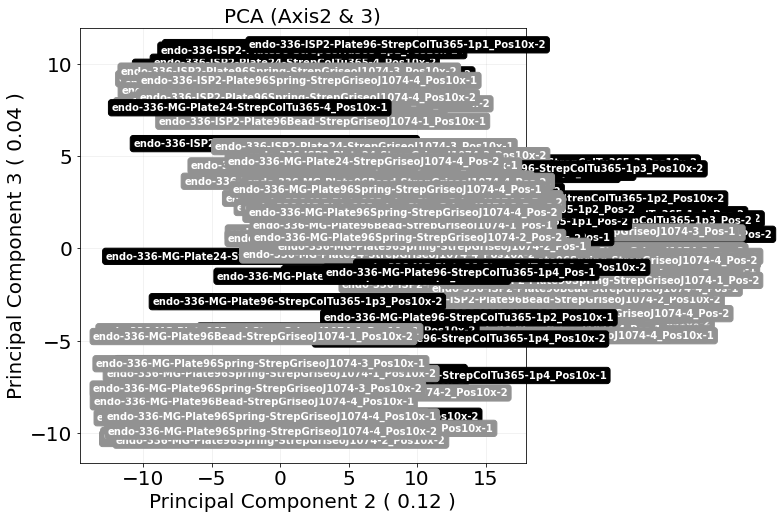

In [96]:
# Make the PCA plot with loadings plot and scree plot for axes 1 to 3
plotPCAwAnnotations(pca, data_plot, True, True)

Data QC #6: Check technical replicate correlation (R > 0.9)

In [24]:
# todo

## Statistical and pathway analyses

Hierarchical clustering analysis without pre-processing

c:\Users\dmccl\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


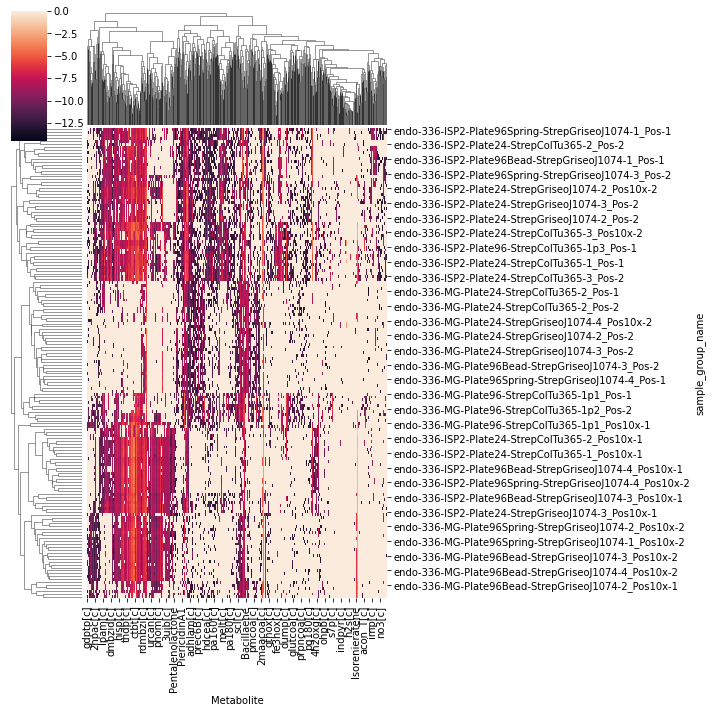

In [97]:
g = sns.clustermap(intensities_piv, method="complete", metric="euclidean")

Clustering analysis with pre-processing using PCA

In [98]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn.preprocessing import OrdinalEncoder

In [99]:
# Pre-process using PCA
intensities_piv_pca = pd.DataFrame(data = comps, columns =  ['pca1', 'pca2',
    'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10'])
intensities_piv_pca.index = intensities_piv.index

In [101]:
# Create the ground truth labels
ord_enc = OrdinalEncoder()
labels_clust = ord_enc.fit_transform(data_plot[["replicate_group_name"]])
n_clust = len(np.unique(labels_clust))
print("n_clusters= ", n_clust)

# Create the clusters using AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=20, linkage="ward") # equivalent of KMeans
Y_preds = clustering.fit_predict(intensities_piv)
Y_preds_preprocessed = clustering.fit_predict(intensities_piv_pca) # with first 10 PCA dims

n_clusters=  20


In [104]:
# Determine the cluster qualty by computing several clustering scores on the original data...
ari = adjusted_rand_score(labels_clust.reshape(labels_clust.shape[0]), Y_preds)
ami = adjusted_mutual_info_score(labels_clust.reshape(labels_clust.shape[0]), Y_preds)
#si = silhouette_score(labels_clust.reshape(labels_clust.shape[0]), Y_preds.reshape(-1,1), metric='euclidean')

# ... and preprocessed data
ari_preprocessed = adjusted_rand_score(labels_clust.reshape(labels_clust.shape[0]), Y_preds_preprocessed)
ami_preprocessed = adjusted_mutual_info_score(labels_clust.reshape(labels_clust.shape[0]), Y_preds_preprocessed)
#si_preprocessed = silhouette_score(labels_clust.reshape(labels_clust.shape[0]), Y_preds_preprocessed.reshape(-1,1), metric='euclidean')
print("adjusted rand index: %s, pre-processed %s", ari, ari_preprocessed)
print("adjusted mutual information: %s, pre-processed %s", ami, ami_preprocessed)
#print("silhouette score: %s, pre-processed %s", si, si_preprocessed)

adjusted rand index: %s, pre-processed %s 0.4112919499890327 0.37294641162452286
adjusted mutual information: %s, pre-processed %s 0.6398729343014975 0.5931560087900544


C:\Users\dmccl\AppData\Local\Temp\ipykernel_45468\1416843090.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.1)


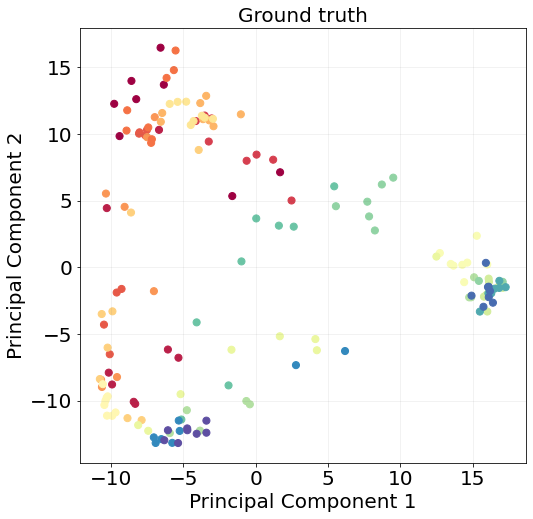

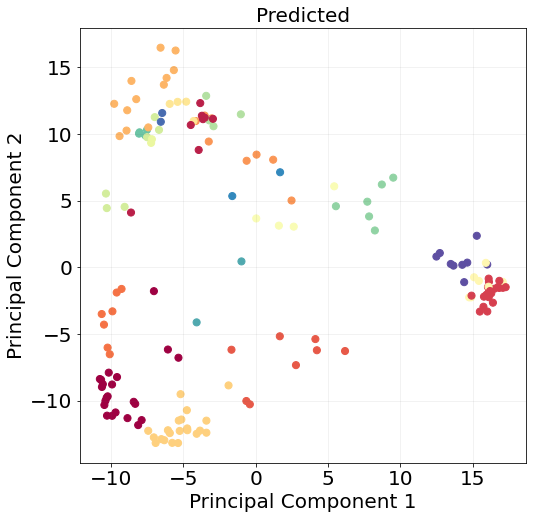

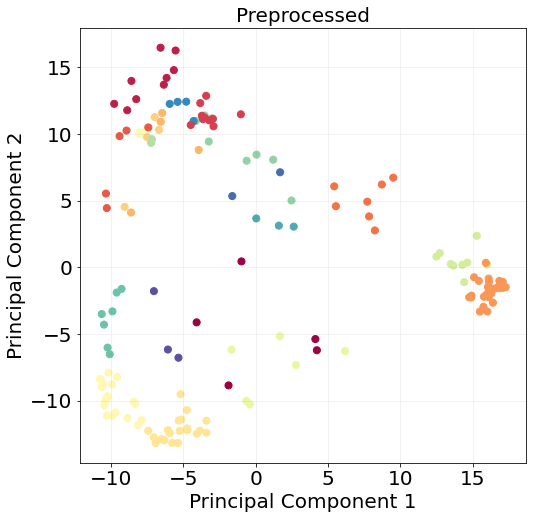

In [105]:
# Overlay of clusters onto PCs 1 and 2
for i in range(0, 3):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component ' + str(1), fontsize = 20)
    ax.set_ylabel('Principal Component ' + str(2), fontsize = 20)
    ax.set_title('Ground truth', fontsize = 20)

    plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.1)
    plt.xticks(size = 20)
    plt.yticks(size = 20)

    if i==0:
        ax.set_title('Ground truth', fontsize = 20)
        plt.scatter(data_plot["pca" + str(1)], data_plot["pca" + str(2)], c=labels_clust, s=50, cmap='Spectral')
    elif i==1:
        ax.set_title('Predicted', fontsize = 20)
        plt.scatter(data_plot["pca" + str(1)], data_plot["pca" + str(2)], c=Y_preds, s=50, cmap='Spectral')
    elif i==2:
        ax.set_title('Preprocessed', fontsize = 20)
        plt.scatter(data_plot["pca" + str(1)], data_plot["pca" + str(2)], c=Y_preds_preprocessed, s=50, cmap='Spectral')


UMAP analysis; see https://umap-learn.readthedocs.io/en/latest

In [31]:
from umap import UMAP

In [106]:
# Create embeddings using the UMAP algorithm
reducer = UMAP() # defaults
umap_embedding = reducer.fit_transform(intensities_piv)
umap_embedding_pca = reducer.fit_transform(intensities_piv_pca)

C:\Users\dmccl\AppData\Local\Temp\ipykernel_45468\836396123.py:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.1)


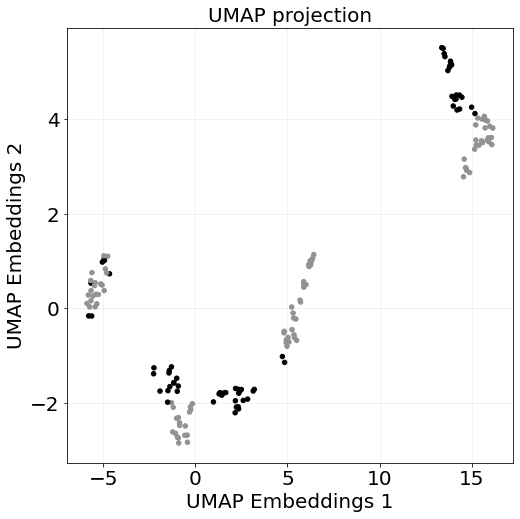

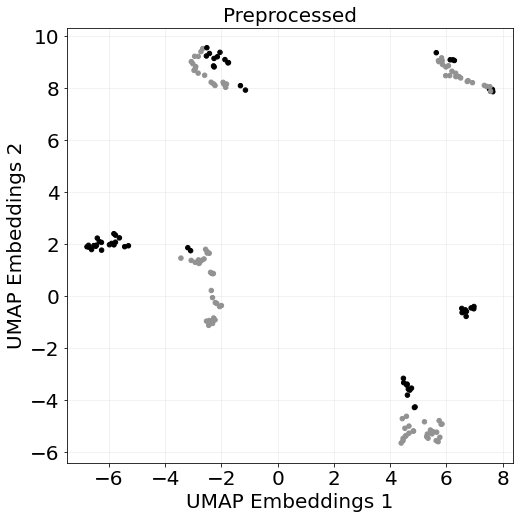

In [107]:
# Plot the first two embeddings
for i in range(0, 2):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('UMAP Embeddings ' + str(1), fontsize = 20)
    ax.set_ylabel('UMAP Embeddings ' + str(2), fontsize = 20)

    plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.1)
    plt.xticks(size = 20)
    plt.yticks(size = 20)

    if i==0:
        ax.set_title('UMAP projection', fontsize = 20)
        ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], color=data_plot["color"], s=20)
        #ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=labels_clust, s=20, cmap='Spectral')
    elif i==1:
        ax.set_title('Preprocessed', fontsize = 20)
        ax.scatter(umap_embedding_pca[:, 0], umap_embedding_pca[:, 1], color=data_plot["color"], s=20)
        #ax.scatter(umap_embedding_pca[:, 0], umap_embedding_pca[:, 1], c=labels_clust, s=20, cmap='Spectral')

#plt.gca().set_aspect('equal', 'datalim')

Pathway enrichment analysis

In [34]:
# todo

Violin plots of individual metabolites of biological interest

In [108]:
# define the metabolites of biological interest
target_mets = []
if batch_name == "MetEngDemo":
    target_mets = database.loc[:,0].iloc[1180:]
else:
    target_mets = database.loc[:,0].iloc[842:875] # [Leu-7]surfactin causes problems in python regex in pandas

# Filter out all other metabolites
violin_plot = intensities_filtered_df[intensities_filtered_df["sample_group_name"].isin(sequence_NPDemo_Pos_Unknown_exo["sample_group_name"].unique())
    & intensities_filtered_df["Metabolite"].isin(target_mets)
]

# Add in the replicate group name
violin_plot = addReplicateGroupNameToDF(violin_plot, sequence)

C:\Users\dmccl\AppData\Local\Temp\ipykernel_45468\1324052703.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["replicate_group_name"] = ""
C:\Users\dmccl\AppData\Local\Temp\ipykernel_45468\1324052703.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["replicate_group_name"] = df["sample_group_name"].apply(getRGNFromSeq, seq=sequence)


AzicemicinA -12.917910821237783
AzicemicinA -12.961107483595262
AzicemicinA -10.746371399287412
AzicemicinA -12.383242254848557
AzicemicinA -11.820191094710884
AzicemicinA -10.905977344460387
AzicemicinA -12.618963462402068
AzicemicinA -12.167428806835915
AzicemicinA -8.50127701430654
AzicemicinA -12.28412514628522
AzicemicinA -10.744442837324655
AzicemicinA -12.662962441772748
AzicemicinA -9.735694724638632
AzicemicinA -10.420436807300707
AzicemicinA -12.253015950879215
AzicemicinA -10.2583408743363
AzicemicinA -12.43705110273012
AzicemicinA -12.077771927814405
AzicemicinA -11.916586545320714
AzicemicinA -11.472355396245172
AzicemicinA -13.106716597789903
AzicemicinA -12.929401733202253
AzicemicinA -11.500208750607722
AzicemicinA -12.5293983971005
AzicemicinA -8.407351285278509
AzicemicinA -12.333075276039049
AzicemicinA -11.236807023917919
AzicemicinA -9.946703040405025
AzicemicinA -10.262885349978436
AzicemicinA -12.14097277579152
AzicemicinA -11.971483987220731
AzicemicinA -12.5247

IndexError: single positional indexer is out-of-bounds

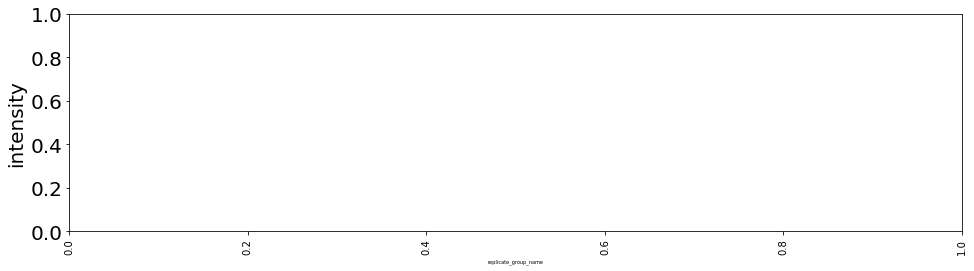

In [128]:
# Plot each of the metabolites of interest
for i in range(0, target_mets.shape[0]):
    violin_plot_subset = violin_plot[violin_plot["Metabolite"].str.contains(target_mets.iloc[i]) & ~violin_plot["Intensity"].isna()]
    if violin_plot_subset.shape[0] > 1:
        fig = plt.figure(figsize = (16,4))
        ax = fig.add_subplot(1,1,1) 
        ax.set_xlabel('replicate_group_name', fontsize = 5)
        ax.set_ylabel('intensity', fontsize = 20)
        plt.xticks(rotation=90)
        plt.yticks(size = 20)
        ax.set_title(target_mets.iloc[i], fontsize = 20)        
        sns.violinplot(x="replicate_group_name", y="Intensity", data=violin_plot_subset, orient = 'v')

In [122]:
violin_plot.head()

,Unnamed: 0,sample_group_name,Metabolite,Formula,Intensity,replicate_group_name
18187,14022,endo-336-ISP2-Plate96Bead-StrepGriseoJ1074-1_P...,Albaflavenone,C15H22O,-8.215705,endo-336-ISP2-Plate96Bead-StrepGriseoJ1074_Pos
18188,14837,endo-336-MG-Plate96Bead-StrepGriseoJ1074-1_Pos-1,Albaflavenone,C15H22O,-9.489129,endo-336-MG-Plate96Bead-StrepGriseoJ1074_Pos
18189,15737,endo-336-ISP2-Plate96Spring-StrepGriseoJ1074-1...,Albaflavenone,C15H22O,-7.859058,endo-336-ISP2-Plate96Spring-StrepGriseoJ1074_Pos
18190,18459,endo-336-ISP2-Plate96Bead-StrepGriseoJ1074-2_P...,Albaflavenone,C15H22O,-9.299777,endo-336-ISP2-Plate96Bead-StrepGriseoJ1074_Pos
18191,20211,endo-336-ISP2-Plate96Spring-StrepGriseoJ1074-2...,Albaflavenone,C15H22O,-8.490878,endo-336-ISP2-Plate96Spring-StrepGriseoJ1074_Pos


Statistical significance between groups

In [110]:
# Filter out all other metabolites
intensities_plot = intensities_filtered_df[intensities_filtered_df["sample_group_name"].isin(sequence_NPDemo_Pos_Unknown_exo["sample_group_name"].unique())
]

# Add in the replicate group name
intensities_plot = addReplicateGroupNameToDF(intensities_plot, sequence)

C:\Users\dmccl\AppData\Local\Temp\ipykernel_45468\1324052703.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["replicate_group_name"] = ""
C:\Users\dmccl\AppData\Local\Temp\ipykernel_45468\1324052703.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["replicate_group_name"] = df["sample_group_name"].apply(getRGNFromSeq, seq=sequence)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'endo-336-ISP2-Plate96Bead-StrepGriseoJ1074_Pos'),
  Text(1, 0, 'endo-336-ISP2-Plate96Spring-StrepGriseoJ1074_Pos'),
  Text(2, 0, 'endo-336-ISP2-Plate24-StrepGriseoJ1074_Pos'),
  Text(3, 0, 'endo-336-ISP2-Plate96-StrepColTu365_Pos'),
  Text(4, 0, 'endo-336-ISP2-Plate24-StrepColTu365_Pos'),
  Text(5, 0, 'endo-336-ISP2-Plate96Bead-StrepGriseoJ1074_Pos10x'),
  Text(6, 0, 'endo-336-ISP2-Plate24-StrepGriseoJ1074_Pos10x'),
  Text(7, 0, 'endo-336-MG-Plate96-StrepColTu365_Pos10x'),
  Text(8, 0, 'endo-336-MG-Plate24-StrepColTu365_Pos10x'),
  Text(9, 0, 'endo-336-ISP2-Plate96-StrepColTu365_Pos10x'),
  Text(10, 0, 'endo-336-ISP2-Plate24-StrepColTu365_Pos10x'),
  Text(11, 0, 'endo-336-MG-Plate96-StrepColTu365_Pos'),
  Text(12, 0, 'endo-336-MG-Plate24-StrepGriseoJ1074_Pos10x'),
  Text(13, 0, 'endo-336-ISP2-Plate96Spring-StrepGriseoJ1074_Pos10x'),
  Text(14, 0, 'endo-336-MG-Plate96Bead-Stre

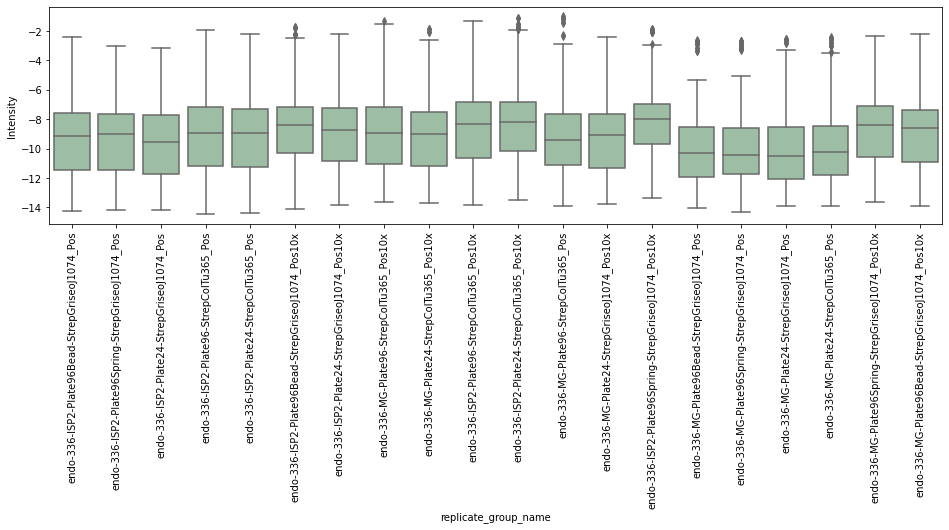

In [111]:
# box plot by conditions
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,1,1) 
ax = sns.boxplot(x='replicate_group_name', y='Intensity', data=intensities_plot, color='#99c2a2')
#ax = sns.swarmplot(x="replicate_group_name", y="Intensity", data=intensities_plot, color='#7d0013')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, 'Albaflavenone'),
  Text(1, 0, 'Bacillaene'),
  Text(2, 0, 'Ectoine'),
  Text(3, 0, 'Geosmin'),
  Text(4, 0, 'Herboxidiene'),
  Text(5, 0, 'Hopene'),
  Text(6, 0, 'Isorenieratene'),
  Text(7, 0, 'Istamycin'),
  Text(8, 0, 'Kirromycin'),
  Text(9, 0, 'Melanin'),
  Text(10, 0, 'Pentalenolactone'),
  Text(11, 0, 'PiericidinA1'),
  Text(12, 0, 'Sch47554'),
  Text(13, 0, 'Sch47555'),
  Text(14, 0, 'Thuggacin'),
  Text(15, 0, 'AzicemicinA'),
  Text(16, 0, 'Bacillibactin'),
  Text(17, 0, 'Lasalocid'),
  Text(18, 0, 'Tetronasin'),
  Text(19, 0, 'Pentamycin'),
  Text(20, 0, 'Stenothricin')])

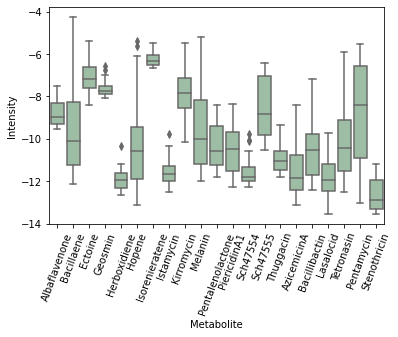

In [112]:
# box plot by metabolite
ax = sns.boxplot(x='Metabolite', y='Intensity', data=violin_plot, color='#99c2a2')
#ax = sns.swarmplot(x="Metabolite", y="Intensity", data=intensities_plot, color='#7d0013')
plt.xticks(rotation=70)

In [45]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [113]:
# perform a two-way ANOVA
model = ols('Intensity ~ C(replicate_group_name) + C(Metabolite) + C(replicate_group_name):C(Metabolite)', data=intensities_plot).fit()
sm.stats.anova_lm(model, typ=2)

ValueError: endog has evaluated to an array with multiple columns that has shape (36360, 36049). This occurs when the variable converted to endog is non-numeric (e.g., bool or str).

In [ ]:
# perform multiple pairwise comparison (Tukey's HSD)
tukey_rgn = pairwise_tukeyhsd(endog=intensities_plot['Intensity'], groups=intensities_plot['replicate_group_name'], alpha=0.05)

# display results
print(tukey_rgn)

Volcano plot

In [ ]:
import sys

In [ ]:
# todo
# calculate the pairwise fold-change and p-value via a t-test

In [ ]:
# Inspired by https://github.com/reneshbedre/bioinfokit

class general:
    def __init__(self):
        pass

    rand_colors = ('#a7414a', '#282726', '#6a8a82', '#a37c27', '#563838', '#0584f2', '#f28a30', '#f05837',
                   '#6465a5', '#00743f', '#be9063', '#de8cf0', '#888c46', '#c0334d', '#270101', '#8d2f23',
                   '#ee6c81', '#65734b', '#14325c', '#704307', '#b5b3be', '#f67280', '#ffd082', '#ffd800',
                   '#ad62aa', '#21bf73', '#a0855b', '#5edfff', '#08ffc8', '#ca3e47', '#c9753d', '#6c5ce7')

    @staticmethod
    def get_figure(show, r, figtype, fig_name, theme):
        if show:
            plt.show()
        else:
            plt.savefig(fig_name+'.'+figtype, format=figtype, bbox_inches='tight', dpi=r)
        if theme == 'dark':
            plt.style.use('default')
        plt.clf()
        plt.close()


    @staticmethod
    def axis_labels(x, y, axlabelfontsize=None, axlabelfontname=None):
        plt.xlabel(x, fontsize=axlabelfontsize, fontname=axlabelfontname)
        plt.ylabel(y, fontsize=axlabelfontsize, fontname=axlabelfontname)
        # plt.xticks(fontsize=9, fontname="sans-serif")
        # plt.yticks(fontsize=9, fontname="sans-serif")

    @staticmethod
    def axis_ticks(xlm=None, ylm=None, axtickfontsize=None, axtickfontname=None, ar=None):
        if xlm:
            plt.xlim(left=xlm[0], right=xlm[1])
            plt.xticks(np.arange(xlm[0], xlm[1], xlm[2]),  fontsize=axtickfontsize, rotation=ar, fontname=axtickfontname)
        else:
            plt.xticks(fontsize=axtickfontsize, rotation=ar, fontname=axtickfontname)

        if ylm:
            plt.ylim(bottom=ylm[0], top=ylm[1])
            plt.yticks(np.arange(ylm[0], ylm[1], ylm[2]),  fontsize=axtickfontsize, rotation=ar, fontname=axtickfontname)
        else:
            plt.yticks(fontsize=axtickfontsize, rotation=ar, fontname=axtickfontname)

    @staticmethod
    def check_for_nonnumeric(pd_series=None):
        if pd.to_numeric(pd_series, errors='coerce').isna().sum() == 0:
            return 0
        else:
            return 1

    @staticmethod
    def pvalue_symbol(pv=None, symbol=None):
        if 0.05 >= pv > 0.01:
            return symbol
        elif 0.01 >= pv > 0.001:
            return 2 * symbol
        elif pv <= 0.001:
            return 3 * symbol
        else:
            return None

    @staticmethod
    def dark_bg():
        plt.style.use('dark_background')

def gene_plot(d, geneid, lfc, lfc_thr, pv_thr, genenames, gfont, pv, gstyle):
        if genenames is not None and genenames == "deg":
            for i in d[geneid].unique():
                if (d.loc[d[geneid] == i, lfc].iloc[0] >= lfc_thr[0] and d.loc[d[geneid] == i, pv].iloc[0] < pv_thr[0]) or \
                        (d.loc[d[geneid] == i, lfc].iloc[0] <= -lfc_thr[1] and d.loc[d[geneid] == i, pv].iloc[0] < pv_thr[1]):
                    if gstyle == 1:
                        plt.text(d.loc[d[geneid] == i, lfc].iloc[0], d.loc[d[geneid] == i, 'logpv_add_axy'].iloc[0], i,
                                      fontsize=gfont)
                    elif gstyle == 2:
                        plt.annotate(i, xy=(d.loc[d[geneid] == i, lfc].iloc[0], d.loc[d[geneid] == i, 'logpv_add_axy'].iloc[0]),
                                     xycoords='data', xytext=(5, -15), textcoords='offset points', size=6,
                                     bbox=dict(boxstyle="round", alpha=0.1),
                                     arrowprops=dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1, relpos=(0, 0)))
                    else:
                        print("Error: invalid gstyle choice")
                        sys.exit(1)
        elif genenames is not None and type(genenames) is tuple:
            for i in d[geneid].unique():
                if i in genenames:
                    if gstyle == 1:
                        plt.text(d.loc[d[geneid] == i, lfc].iloc[0], d.loc[d[geneid] == i, 'logpv_add_axy'].iloc[0], i,
                                      fontsize=gfont)
                    elif gstyle == 2:
                        plt.annotate(i, xy=(d.loc[d[geneid] == i, lfc].iloc[0], d.loc[d[geneid] == i, 'logpv_add_axy'].iloc[0]),
                                     xycoords='data', xytext=(5, -15), textcoords='offset points', size=6,
                                     bbox=dict(boxstyle="round", alpha=0.1),
                                     arrowprops=dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1, relpos=(0, 0)))
                    else:
                        print("Error: invalid gstyle choice")
                        sys.exit(1)
        elif genenames is not None and type(genenames) is dict:
            for i in d[geneid].unique():
                if i in genenames:
                    if gstyle == 1:
                        plt.text(d.loc[d[geneid] == i, lfc].iloc[0], d.loc[d[geneid] == i, 'logpv_add_axy'].iloc[0],
                                      genenames[i], fontsize=gfont)
                    elif gstyle == 2:
                        plt.annotate(genenames[i], xy=(d.loc[d[geneid] == i, lfc].iloc[0], d.loc[d[geneid] == i, 'logpv_add_axy'].iloc[0]),
                                     xycoords='data', xytext=(5, -15), textcoords='offset points', size=6,
                                     bbox=dict(boxstyle="round", alpha=0.1),
                                     arrowprops=dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1, relpos=(0, 0)))
                    else:
                        print("Error: invalid gstyle choice")
                        sys.exit(1)

def volcano(df="dataframe", lfc=None, pv=None, lfc_thr=(1, 1), pv_thr=(0.05, 0.05), color=("green", "grey", "red"),
                valpha=1, geneid=None, genenames=None, gfont=8, dim=(5, 5), r=300, ar=90, dotsize=8, markerdot="o",
                sign_line=False, gstyle=1, show=False, figtype='png', axtickfontsize=9,
                axtickfontname="Arial", axlabelfontsize=9, axlabelfontname="Arial", axxlabel=None,
                axylabel=None, xlm=None, ylm=None, plotlegend=False, legendpos='best',
                figname='volcano', legendanchor=None,
                legendlabels=['significant up', 'not significant', 'significant down'], theme=None):
        _x = r'$ log_{2}(Fold Change)$'
        _y = r'$ -log_{10}(P-value)$'
        color = color
        # check if dataframe contains any non-numeric character
        assert general.check_for_nonnumeric(df[lfc]) == 0, 'dataframe contains non-numeric values in lfc column'
        assert general.check_for_nonnumeric(df[pv]) == 0, 'dataframe contains non-numeric values in pv column'
        # this is important to check if color or logpv exists and drop them as if you run multiple times same command
        # it may update old instance of df
        df = df.drop(['color_add_axy', 'logpv_add_axy'], axis=1, errors='ignore')
        assert len(set(color)) == 3, 'unique color must be size of 3'
        df.loc[(df[lfc] >= lfc_thr[0]) & (df[pv] < pv_thr[0]), 'color_add_axy'] = color[0]  # upregulated
        df.loc[(df[lfc] <= -lfc_thr[1]) & (df[pv] < pv_thr[1]), 'color_add_axy'] = color[2]  # downregulated
        df['color_add_axy'].fillna(color[1], inplace=True)  # intermediate
        df['logpv_add_axy'] = -(np.log10(df[pv]))
        # plot
        assign_values = {col: i for i, col in enumerate(color)}
        color_result_num = [assign_values[i] for i in df['color_add_axy']]
        assert len(set(color_result_num)) == 3, \
            'either significant or non-significant genes are missing; try to change lfc_thr or pv_thr to include ' \
            'both significant and non-significant genes'
        if theme == 'dark':
            general.dark_bg()
        plt.subplots(figsize=dim)
        if plotlegend:
            s = plt.scatter(df[lfc], df['logpv_add_axy'], c=color_result_num, cmap=ListedColormap(color), alpha=valpha,
                            s=dotsize, marker=markerdot)
            assert len(legendlabels) == 3, 'legendlabels must be size of 3'
            plt.legend(handles=s.legend_elements()[0], labels=legendlabels, loc=legendpos, bbox_to_anchor=legendanchor)
        else:
            plt.scatter(df[lfc], df['logpv_add_axy'], c=color_result_num, cmap=ListedColormap(color), alpha=valpha,
                        s=dotsize, marker=markerdot)
        if sign_line:
            plt.axhline(y=-np.log10(pv_thr[0]), linestyle='--', color='#7d7d7d', linewidth=1)
            plt.axvline(x=lfc_thr[0], linestyle='--', color='#7d7d7d', linewidth=1)
            plt.axvline(x=-lfc_thr[1], linestyle='--', color='#7d7d7d', linewidth=1)
        gene_plot(df, geneid, lfc, lfc_thr, pv_thr, genenames, gfont, pv, gstyle)

        if axxlabel:
            _x = axxlabel
        if axylabel:
            _y = axylabel
        general.axis_labels(_x, _y, axlabelfontsize, axlabelfontname)
        general.axis_ticks(xlm, ylm, axtickfontsize, axtickfontname, ar)
        general.get_figure(show, r, figtype, figname, theme)

In [ ]:
volcano(df=df, lfc='log2FC', pv='p-value', show=True, geneid="Metabolites")